In [1]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

#libraries
import pandas as pd
import numpy as np 
import seaborn as sn
import matplotlib as mt
import sklearn as sk
import scipy as sc
import statsmodels as st
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns

from utils import standardize, jitter, SMWrapper, AddInteractions, PartialStandardScaler, plot_model_coefs

%load_ext autoreload
%autoreload 2

In [2]:
url = 'https://bitbucket.org/swidrak/swidrak-pochwatko/raw/08903603d07e11f4d48ca78359233e474b94df5b/jmui.xlsx'
data_df = pd.read_excel(url)

In [3]:
stim_factor = sm.tools.categorical(data_df.stimulus, drop=True)
stim_factor = stim_factor.rename(columns={0: 'none', 1: 'sound', 2: 'touch'})
offer_num = data_df.offer.map({'generous': 2, 'fair': 1, 'unfair': 0})
offer_num.name = 'offer_num'
data_df = pd.concat([data_df, stim_factor.set_index(data_df.index), offer_num], axis=1)
data_df['different_gen'] = np.logical_not(data_df.agent_gen != data_df.participant_gen).astype(int)
data_df.head()

study unique  id  round  agent_num agent_name  agent_gen agent_gender  \
0      1   i3r1   3      1          2   Karolina          1       female   
1      1   i3r2   3      2          1      Tomek          0         male   
2      1   i3r3   3      3          2   Karolina          1       female   
3      1   i3r4   3      4          1      Tomek          0         male   
4      1   i3r5   3      5          1      Tomek          0         male   

   participant_pro  participant_gen  ...         1         2         3  \
0                0                0  ...  0.812898  0.242467 -0.720298   
1                0                0  ...  0.961918  0.146714 -0.798799   
2                1                0  ...  1.182986  1.558825  3.092469   
3                1                0  ... -5.547718 -5.771800 -6.657633   
4                1                0  ... -0.177659  0.178411  3.395282   

          4         5 none  sound touch  offer_num  different_gen  
0 -1.975114 -3.273493    0      0     1          2              0  
1 -0.798799 -0.364786    1      0     0          2              1  
2  2.781798  2.242901    0      0     1          1              0  
3 -7.239025 -4.869054    1      0     0          1              1  
4  3.847108  5.164053    0      1     0          1              1  

[5 rows x 40 columns]

# Study 1

## Complete pooling

In [4]:
data_notpro = data_df[(data_df.participant_pro==0) & (data_df.study==1)]

In [39]:
y = data_notpro.accepted  # define dependent variable

#zXa = sm.add_constant(data_notpro[['agent_gen', 'participant_gen',
#             'touch', 'sound', 'offer_par', 'masculinity']]) # add ones vector
zXa = sm.add_constant(pd.concat([standardize(data_notpro[['offer_par', 'masculinity']], scale_factor=1),
                                 data_notpro[['agent_gen', 'participant_gen', 'touch', 'sound']]], axis=1)) 

zXa['participant_gen:masculinity'] = zXa.participant_gen * zXa.masculinity
zXa['participant_gen:touch'] = zXa.participant_gen * zXa.touch

model = sm.Logit(y, zXa)  # define model
res_OLS = model.fit()
res_OLS.summary()

Optimization terminated successfully.
         Current function value: 0.464107
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accepted   No. Observations:                  660
Model:                          Logit   Df Residuals:                      651
Method:                           MLE   Df Model:                            8
Date:                Thu, 11 Jun 2020   Pseudo R-squ.:                  0.1568
Time:                        15:01:44   Log-Likelihood:                -306.31
converged:                       True   LL-Null:                       -363.25
Covariance Type:            nonrobust   LLR p-value:                 6.058e-21
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           1.6832      0.248      6.781      0.000       1.197       2.170
offer_par                       0.7852      0.105      7.464      0.000       0.579       0.991
masculinity                     0.1195      0.148      0.807      0.420      -0.171       0.410
agent_gen                       0.1557      0.204      0.764      0.445      -0.244       0.555
participant_gen                -0.9017      0.253     -3.565      0.000      -1.397      -0.406
touch                          -0.3769      0.319     -1.183      0.237      -1.001       0.248
sound                          -0.1811      0.246     -0.735      0.462      -0.664       0.302
participant_gen:masculinity     0.8924      0.247      3.611      0.000       0.408       1.377
participant_gen:touch           0.7144      0.437      1.634      0.102      -0.143       1.571
===============================================================================================
"""

1. The offer is very relevant to determine the decision to accept the offer
2. Female accept significantly more offers than males
3. Masculinity has barely an effect on women (coefficient small and non significant)
4. Masculinity has a significant effect on men (interaction large and significant)
5. The effect of touch is not significant but has different directions for men and women, which seems interesting
6. Sound, agent gender and the interaction between the offer and participant gender (not included in this model) are not significant.

In [40]:
pred_accuracy = np.mean(((res_OLS.predict(zXa) > 0.5) & (y==1)) | ((res_OLS.predict(zXa) < 0.5) & (y==0)))
pred_accuracy_null = np.sum(y==1) / len(y)
print("Prediction accuracy is: {:.2f}, accuracy of null model is: {:.2f}".format(pred_accuracy, pred_accuracy_null))

Prediction accuracy is: 0.81, accuracy of null model is: 0.76


/home/andrea/anaconda3/envs/mamba/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


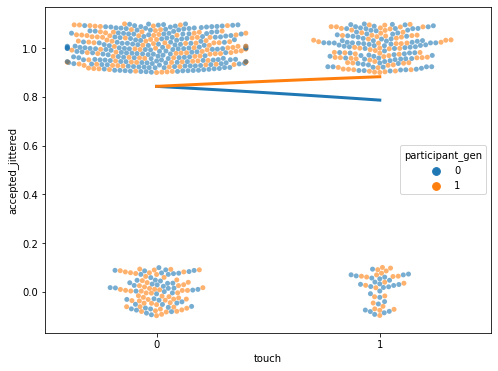

In [78]:
data_notpro['accepted_jittered'] = jitter(data_notpro.accepted, 0.2)
fig, ax = plt.subplots(figsize=[8, 6])
sns.swarmplot(x='touch', y='accepted_jittered', hue='participant_gen', data=data_notpro, ax=ax, alpha=0.6)
xx = np.linspace(0, 1, 100)
ax.plot(xx, sc.special.expit(res_OLS.params.const + xx*res_OLS.params.touch),
        linewidth=3, label='participant female')
ax.plot(xx, sc.special.expit(res_OLS.params.const + xx*(res_OLS.params.touch+res_OLS.params['participant_gen:touch'])),
        linewidth=3, label='participant male')

## No pooling

It's not possible to estimate the model with data from individual subjects (even a very simple model): too few samples.

## Cross-validation

Leave-one-subject out cross-validation shows that coefficients are stable to small variations in dataset. 

In [50]:
subjects = data_notpro.id
n_subj = len(subjects.unique())
kFold = GroupKFold(n_splits=n_subj)  # equivalent to leave one group out
pipe = Pipeline(steps=[('scaler', PartialStandardScaler(all_but=['const', 'agent_gen', 'participant_gen', 'touch', 'sound'])),
                       ('interactions', AddInteractions([('masculinity', 'participant_gen'), ('touch', 'participant_gen')])),
                       ('model', SMWrapper(sm.Logit))])
y = data_notpro.accepted  # define dependent variable
X = data_notpro[['offer_par', 'masculinity', 'agent_gen', 'participant_gen', 'touch', 'sound']]
scores = np.zeros(n_subj)
scores_null = np.zeros(n_subj)
results = dict()
for i, (train_i, test_i) in enumerate(kFold.split(X, y, groups=subjects)):
    X_train, X_test = X.iloc[train_i, :], X.iloc[test_i, :]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    pipe.fit(X_train, y_train)
    scores[i] = pipe.score(X_test, y_test)
    scores_null[i] = np.sum(y_test==1) / len(y_test)
    scores_null[i] = scores_null[i] if scores_null[i]>0.5 else 1-scores_null[i]
    results[i] = pipe.steps[-1][-1].results_



Optimization terminated successfully.
         Current function value: 0.466014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.454442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467083
  

Text(0.5, 0, 'test accuracy')

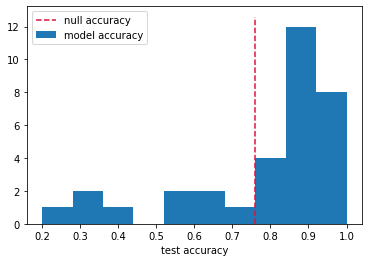

In [51]:
plt.figure()
plt.hist(scores, label='model accuracy');
ylims = plt.ylim()
plt.plot([pred_accuracy_null, pred_accuracy_null], ylims, '--', color='crimson', label='null accuracy')
plt.legend()
plt.xlabel('test accuracy')

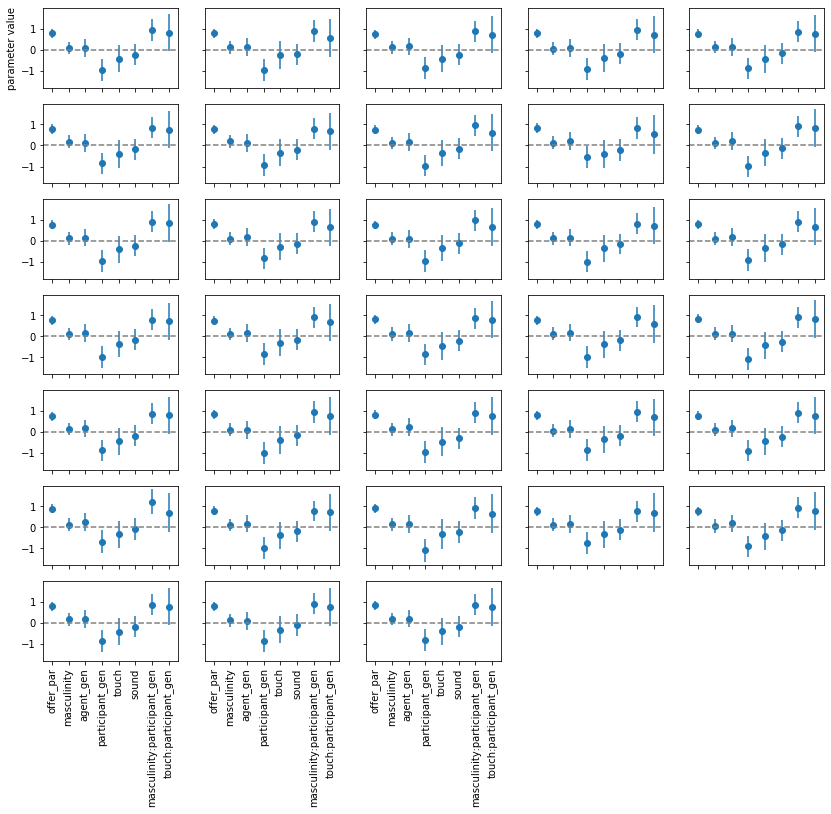

In [73]:
ncols = 5
fig, axs = plt.subplots(nrows=int(np.ceil(n_subj/ncols)), ncols=ncols, figsize=[14, 12], sharex=True, sharey=True)
for s, ax in enumerate(axs.flatten()):
    if s < n_subj:
        plot_model_coefs(results[s], ax=ax)
        xlims = ax.get_xlim()
        ax.plot(xlims, [0, 0], '--', color='grey')
        ax.set_xlim(xlims)
    ax.tick_params(axis='x', rotation=90)
axs[0, 0].set_ylabel('parameter value')
fig.delaxes(axs[-1, -2])
fig.delaxes(axs[-1, -1])

# Study 2

## Distribution of masculinity for the four agents

The reported masculinity is different on average between male and female agents and between masculine and feminine agents within each agent gender group however there's a considerable overlap among distributions. For this reason it's probably better to use the reported masculinity instead of the dichotomous variable.

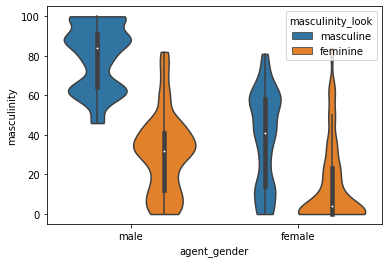

In [25]:
data_2 = data_df[data_df.study==2]
subjIDs = data_2.id.unique()
sns.violinplot(data=data_2, x='agent_gender', y='masculinity', hue='masculinity_look', cut=0)

## Complete pooling

In [45]:
data_2notpro = data_2[(data_2.participant_pro==0)]
y = data_2notpro.accepted  # define dependent variable

#zXa = sm.add_constant(data_2notpro[['agent_gen', 'participant_gen',
#             'touch', 'sound', 'offer_par', 'masculinity']]) # add ones vector
zXa = sm.add_constant(pd.concat([standardize(data_2notpro[['offer_par', 'masculinity']], scale_factor=1),
                                 data_2notpro[['agent_gen', 'touch', 'sound']]], axis=1)) 


zXa['agent_gen:offer_par'] = zXa.agent_gen * zXa.offer_par

model = sm.Logit(y, zXa)  # define model
res_OLS = model.fit()
res_OLS.summary()

Optimization terminated successfully.
         Current function value: 0.375105
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accepted   No. Observations:                 1914
Model:                          Logit   Df Residuals:                     1907
Method:                           MLE   Df Model:                            6
Date:                Fri, 12 Jun 2020   Pseudo R-squ.:                  0.2984
Time:                        11:12:42   Log-Likelihood:                -717.95
converged:                       True   LL-Null:                       -1023.4
Covariance Type:            nonrobust   LLR p-value:                1.067e-128
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.0018      0.171     11.725      0.000       1.667       2.336
offer_par               1.9917      0.144     13.839      0.000       1.710       2.274
masculinity             0.1299      0.075      1.736      0.083      -0.017       0.277
agent_gen              -0.0799      0.191     -0.418      0.676      -0.454       0.294
touch                  -0.0684      0.161     -0.426      0.670      -0.383       0.246
sound                  -0.0409      0.166     -0.246      0.805      -0.366       0.284
agent_gen:offer_par    -0.4205      0.188     -2.236      0.025      -0.789      -0.052
=======================================================================================
"""

1. the offer clearly affect the acceptance
2. but it affects less when the agent is a female character (significant large interaction)
3. the gender of the agent is not relevant by itself
4. masculinity slightly (and not significantly) increase the probability of accepting the offer
5. touch and sound are irrelevant 
6. interaction between touch and all other variables (offer, gender, masculinity) is not significant

In [46]:
pred_accuracy = np.mean(((res_OLS.predict(zXa) > 0.5) & (y==1)) | ((res_OLS.predict(zXa) < 0.5) & (y==0)))
pred_accuracy_null = np.sum(y==1) / len(y)
print("Prediction accuracy is: {:.2f}, accuracy of null model is: {:.2f}".format(pred_accuracy, pred_accuracy_null))

Prediction accuracy is: 0.84, accuracy of null model is: 0.77


This figure show the effect of the offer and the interaction with agent gender/

/home/andrea/anaconda3/envs/mamba/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


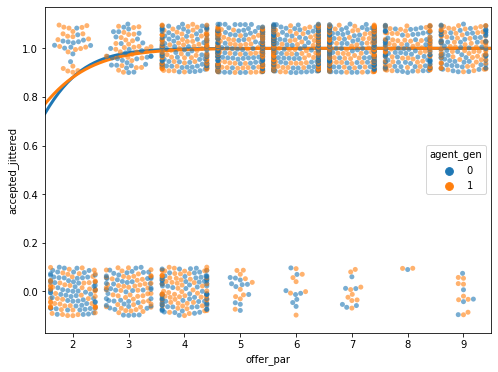

In [50]:
data_2notpro['accepted_jittered'] = jitter(data_2notpro.accepted, 0.2)
fig, ax = plt.subplots(figsize=[8, 6])
sns.swarmplot(x='offer_par', y='accepted_jittered', hue='agent_gen', data=data_2notpro, ax=ax, alpha=0.6)
xlims = ax.get_xlim()
xx = np.linspace(xlims[0], xlims[1], 100)
ax.plot(xx, sc.special.expit(res_OLS.params.const + xx*res_OLS.params.offer_par),
        linewidth=3, label='participant male')
ax.plot(xx, sc.special.expit(res_OLS.params.const + xx*(res_OLS.params.offer_par+res_OLS.params['agent_gen:offer_par'])),
        linewidth=3, label='participant female')
#ax.set_xlim(xlims);

## Cross-validation

Leave-one-subject out cross-validation shows that coefficients are stable to small variations in dataset. Coefficient values are stable across CV folds.

In [51]:
subjects = data_2notpro.id
n_subj = len(subjects.unique())
kFold = GroupKFold(n_splits=n_subj)  # equivalent to leave one group out
pipe = Pipeline(steps=[('scaler', PartialStandardScaler(all_but=['const', 'agent_gen', 'touch', 'sound'])),
                       ('interactions', AddInteractions([('agent_gen', 'offer_par')])),
                       ('model', SMWrapper(sm.Logit))])
y = data_2notpro.accepted  # define dependent variable
X = data_2notpro[['offer_par', 'masculinity', 'agent_gen', 'touch', 'sound']]
scores = np.zeros(n_subj)
scores_null = np.zeros(n_subj)
results = dict()
for i, (train_i, test_i) in enumerate(kFold.split(X, y, groups=subjects)):
    X_train, X_test = X.iloc[train_i, :], X.iloc[test_i, :]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    pipe.fit(X_train, y_train)
    scores[i] = pipe.score(X_test, y_test)
    scores_null[i] = np.sum(y_test==1) / len(y_test)
    scores_null[i] = scores_null[i] if scores_null[i]>0.5 else 1-scores_null[i]
    results[i] = pipe.steps[-1][-1].results_



Optimization terminated successfully.
         Current function value: 0.377207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369146
  

Text(0.5, 0, 'test accuracy')

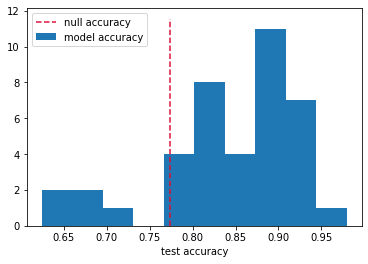

In [52]:
plt.figure()
plt.hist(scores, label='model accuracy');
ylims = plt.ylim()
plt.plot([pred_accuracy_null, pred_accuracy_null], ylims, '--', color='crimson', label='null accuracy')
plt.legend()
plt.xlabel('test accuracy')

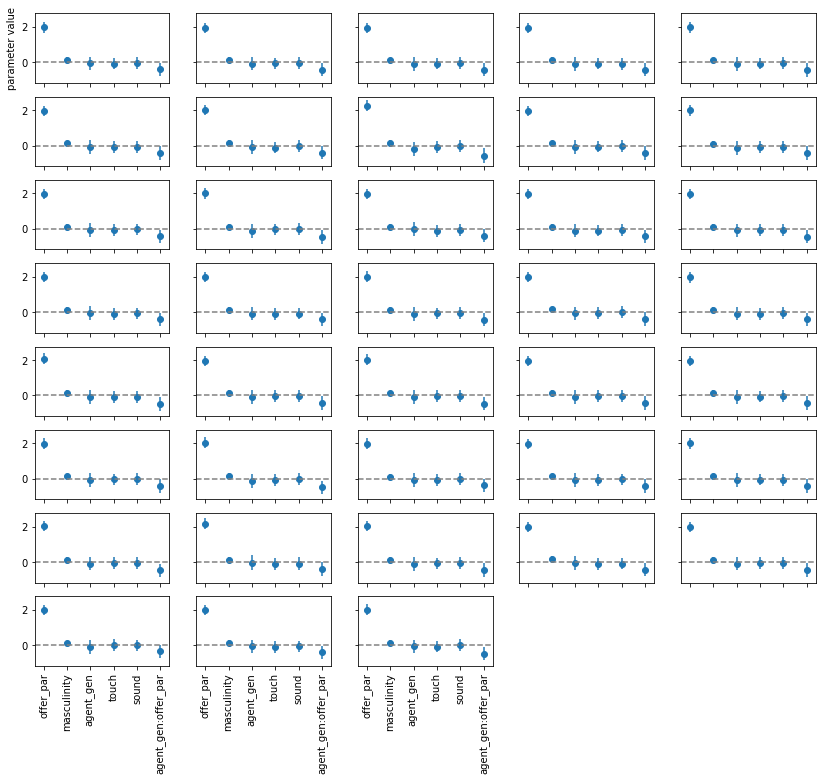

In [53]:
ncols = 5
fig, axs = plt.subplots(nrows=int(np.ceil(n_subj/ncols)), ncols=ncols, figsize=[14, 12], sharex=True, sharey=True)
for s, ax in enumerate(axs.flatten()):
    if s < n_subj:
        plot_model_coefs(results[s], ax=ax)
        xlims = ax.get_xlim()
        ax.plot(xlims, [0, 0], '--', color='grey')
        ax.set_xlim(xlims)
    ax.tick_params(axis='x', rotation=90)
axs[0, 0].set_ylabel('parameter value')
fig.delaxes(axs[-1, -2])
fig.delaxes(axs[-1, -1])

# Study 3

## Complete pooling

The reported status is different on average between between low and high agent status however there's a considerable overlap between the distributions. There is also a larger difference for the female character and the estimated status of low status female character is lower compared to the male character. For this reason it's probably better to use the reported status instead of the dichotomous variable.

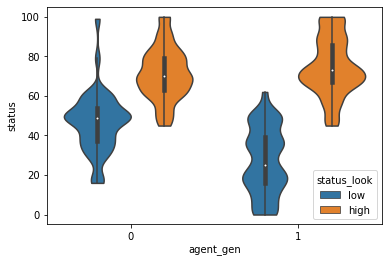

In [95]:
data_3 = data_df[data_df.study==3]
status_factor = sm.tools.categorical(data_3.status_look, drop=True)
status_factor = status_factor.rename(columns={'low': 'status_low', 'high': 'status_high'})
data_3 = pd.concat([data_3, status_factor.set_index(data_3.index)], axis=1)
subjIDs = data_3.id.unique()
sns.violinplot(data=data_3, x='agent_gen', y='status', hue='status_look', cut=0)

In [108]:
data_3notpro = data_3[(data_3.participant_pro==0)]
y = data_3notpro.accepted  # define dependent variable

#zXa = sm.add_constant(data_2notpro[['agent_gen', 'participant_gen',
#             'touch', 'sound', 'offer_par', 'masculinity']]) # add ones vector
zXa = sm.add_constant(pd.concat([standardize(data_3notpro[['offer_par', 'masculinity', 'status']], scale_factor=1),
                                 data_3notpro[['agent_gen', 'touch', 'sound']]], axis=1)) 


zXa['status:offer_par'] = zXa.status * zXa.offer_par


model = sm.Logit(y, zXa)  # define model
res_OLS = model.fit()
res_OLS.summary()

Optimization terminated successfully.
         Current function value: 0.459016
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accepted   No. Observations:                 1965
Model:                          Logit   Df Residuals:                     1957
Method:                           MLE   Df Model:                            7
Date:                Fri, 12 Jun 2020   Pseudo R-squ.:                  0.2756
Time:                        13:26:07   Log-Likelihood:                -901.97
converged:                       True   LL-Null:                       -1245.1
Covariance Type:            nonrobust   LLR p-value:                6.103e-144
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9525      0.129      7.381      0.000       0.700       1.205
offer_par            1.5998      0.078     20.408      0.000       1.446       1.753
masculinity          0.1393      0.082      1.693      0.091      -0.022       0.301
status               0.1645      0.065      2.547      0.011       0.038       0.291
agent_gen            0.3191      0.167      1.912      0.056      -0.008       0.646
touch               -0.1716      0.143     -1.200      0.230      -0.452       0.109
sound               -0.1179      0.143     -0.824      0.410      -0.398       0.163
status:offer_par    -0.1541      0.079     -1.950      0.051      -0.309       0.001
====================================================================================
"""

1. the offer clearly a positive affect the acceptance
2. when the perceived status is below (above) average the offer effect is stronger (weaker)
3. higher perceived status per se also increases the probability of accepting the offer
5. touch and sound are irrelevant 
6. interaction between touch and all other variables (offer, gender, masculinity) is not significant

In [109]:
pred_accuracy = np.mean(((res_OLS.predict(zXa) > 0.5) & (y==1)) | ((res_OLS.predict(zXa) < 0.5) & (y==0)))
pred_accuracy_null = np.sum(y==1) / len(y)
print("Prediction accuracy is: {:.2f}, accuracy of null model is: {:.2f}".format(pred_accuracy, pred_accuracy_null))

Prediction accuracy is: 0.79, accuracy of null model is: 0.67


This figure shows the dependence on offer value and interaction with perceived status. Dots are colored according to agent designed status although we don't use it to build the model.

/home/andrea/anaconda3/envs/mamba/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


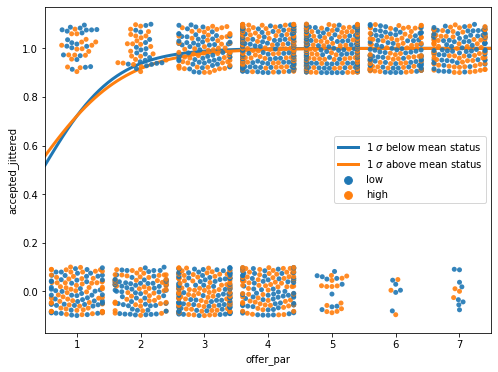

In [141]:
data_3notpro['accepted_jittered'] = jitter(data_3notpro.accepted, 0.2)
fig, ax = plt.subplots(figsize=[8, 6])
g = sns.swarmplot(x='offer_par', y='accepted_jittered', data=data_3notpro, hue='status_look', #color='pink',
                  ax=ax, alpha=0.9)
xlims = ax.get_xlim()
xx = np.linspace(xlims[0], xlims[1], 100)
artist1 = ax.plot(xx, sc.special.expit(res_OLS.params.const + xx*(res_OLS.params.offer_par-1*res_OLS.params['status:offer_par'])),
        linewidth=3, label=r'1 $\sigma$ below mean status')
artist2 = ax.plot(xx, sc.special.expit(res_OLS.params.const + xx*(res_OLS.params.offer_par+1*res_OLS.params['status:offer_par'])),
        linewidth=3, label=r'1 $\sigma$ above mean status')
plt.legend()

## Cross-Validation

Leave-one-subject out cross-validation shows that coefficients are stable to small variations in dataset. Coefficient values are stable across CV folds.

In [142]:
subjects = data_3notpro.id
n_subj = len(subjects.unique())
kFold = GroupKFold(n_splits=n_subj)  # equivalent to leave one group out
pipe = Pipeline(steps=[('scaler', PartialStandardScaler(all_but=['const', 'agent_gen', 'touch', 'sound'])),
                       ('interactions', AddInteractions([('status', 'offer_par')])),
                       ('model', SMWrapper(sm.Logit))])
y = data_3notpro.accepted  # define dependent variable
X = data_3notpro[['offer_par', 'masculinity', 'status', 'agent_gen', 'touch', 'sound']]
scores = np.zeros(n_subj)
scores_null = np.zeros(n_subj)
results = dict()
for i, (train_i, test_i) in enumerate(kFold.split(X, y, groups=subjects)):
    X_train, X_test = X.iloc[train_i, :], X.iloc[test_i, :]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    pipe.fit(X_train, y_train)
    scores[i] = pipe.score(X_test, y_test)
    scores_null[i] = np.sum(y_test==1) / len(y_test)
    scores_null[i] = scores_null[i] if scores_null[i]>0.5 else 1-scores_null[i]
    results[i] = pipe.steps[-1][-1].results_

Optimization terminated successfully.
         Current function value: 0.460858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.454804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.461105
  

Text(0.5, 0, 'test accuracy')

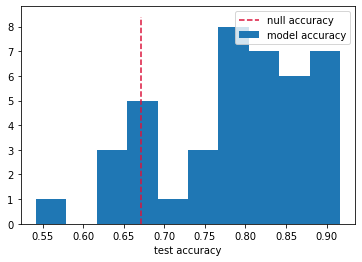

In [143]:
plt.figure()
plt.hist(scores, label='model accuracy');
ylims = plt.ylim()
plt.plot([pred_accuracy_null, pred_accuracy_null], ylims, '--', color='crimson', label='null accuracy')
plt.legend()
plt.xlabel('test accuracy')

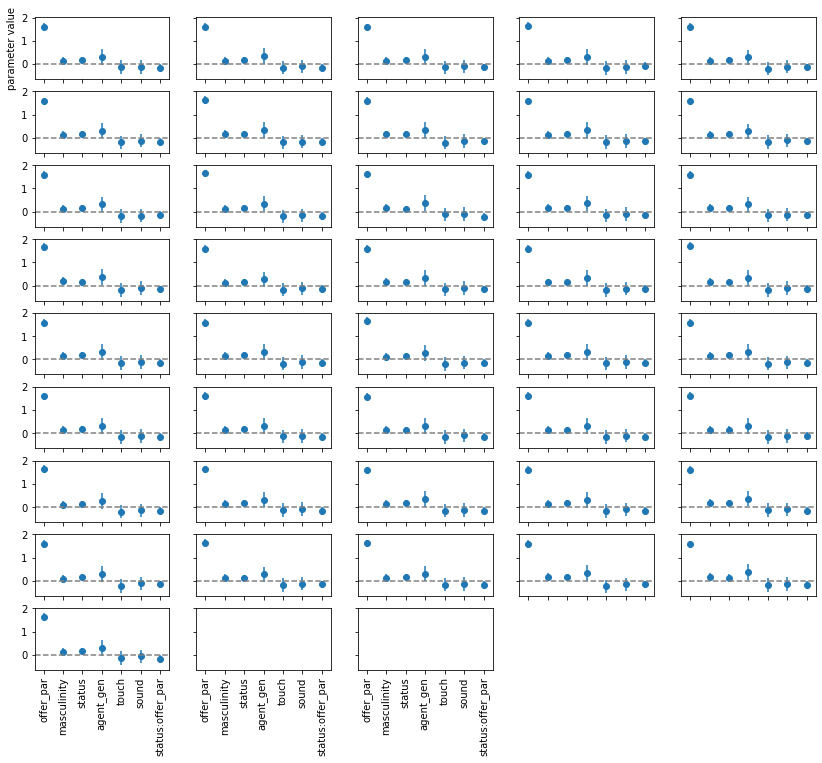

In [147]:
ncols = 5
fig, axs = plt.subplots(nrows=int(np.ceil(n_subj/ncols)), ncols=ncols, figsize=[14, 12], sharex=True, sharey=True)
for s, ax in enumerate(axs.flatten()):
    if s < n_subj:
        plot_model_coefs(results[s], ax=ax)
        xlims = ax.get_xlim()
        ax.plot(xlims, [0, 0], '--', color='grey')
        ax.set_xlim(xlims)
    ax.tick_params(axis='x', rotation=90)
axs[0, 0].set_ylabel('parameter value')
fig.delaxes(axs[-1, -2])
fig.delaxes(axs[-1, -1])